In [1]:
import numpy as np
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
def HankelMatrix(X, L):
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [3]:
def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))
    
#     if len(point) == 3:
#         x, y, z = point
#         r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
#         theta = np.arctan2(np.sqrt(x**2 + y**2), z)
#         phi = np.arctan2(y, x)
#         #print(r * np.cos(theta))
#         return theta, phi, r
    
    

    
def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    

def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian

In [4]:
def matpower(a, alpha):
    a = (a + a.T) / 2
    eigenValues, eigenVectors = np.linalg.eig(a)
    return np.dot(np.dot(eigenVectors, np.diag(eigenValues ** alpha)), eigenVectors.T)

# Sufficient dimension reduction problem:
# X ~ R^p
# Y ~ R
# Y depends only on beta^T X
# beta: p x r

def directional_regression(x, y, h, r):
    np.random.seed(200)
    # x[i, j] = i'th object, j'th feature

    # number of objects
    n = x.shape[0]
    # dimension to reduce, r is target dimension, r <= p
    p = x.shape[1]

    r_var = np.cov(x.T)

    signrt = matpower(r_var, -0.5)

    #xst = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    xst = np.dot(x - np.mean(x, axis=0), signrt)

    #bin_count = 10
    hist = np.histogram(y, bins=h)
    y_bins = np.fmin(np.digitize(y, hist[1]), h) - 1

    prob = np.zeros(h)
    for i in range(h):
        prob[i] = np.sum(y_bins == i) / n
        
    vxy = np.zeros((p, p, h))
    exy = np.zeros((h, p))
    for i in range(h):
        vxy[:,:,i] = np.cov(xst[y_bins == i, :].T)
        exy[i,:] = np.mean(xst[y_bins == i, :], axis=0)

    mat1 = np.zeros((p, p))
    mat2 = np.zeros((p, p))

    for i in range(h):
#         print("i =", i)
        A = exy[i,:][:,np.newaxis].dot(exy[i,:][:,np.newaxis].T)
        B = vxy[:,:,i] + A
        
#         print('vxy:', vxy[:,:,i])
#         print("B:", B)
        mat1 += prob[i] * B.dot(B)
        mat2 += prob[i] * A

    out = 2 * mat1 + 2 * mat2.dot(mat2) + 2 * np.sum(np.diag(mat2))*mat2 - 2 * np.eye(p)
    
    
#     print("prob:", prob)
#     print("mat1:", mat1)
    
    eigenValues, eigenVectors = np.linalg.eig(out)

    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    output = np.zeros((n, r))

    for i in range(r):
        u = eigenVectors[i,:]
#         print('Eigen vector {}'.format(u))
        output[:, i] = u.dot(x.T)

    return output

In [5]:
def ApplyDR(trajectory, r=2, h=30):
    y = trajectory[:, -1]
    X = trajectory[:, :-1]
    
    pred = directional_regression(X, y, h, r)
    return pred

In [6]:
def add_free(X):
    return np.hstack([X, np.ones(shape=(X.shape[0], 1))])

In [7]:
def MakeStationary(ts):
    new_ts = []
    for i in range(1, len(ts)):
        new_ts.append(ts[i] - ts[i - 1])
    return np.array(new_ts)

In [8]:
print(SphericalToCartesian(CartesianToSpherical(np.array([1.0, 2.0, 3.0]))))
print(SphericalToCartesian(CartesianToSpherical(np.array([1.0, -2.0, 1234.0]))))

[1. 2. 3.]
[ 1.000e+00 -2.000e+00  1.234e+03]


### Реальные данные

In [26]:
data = pd.read_csv('EnergyConsumption.csv').iloc[:, 3:]

In [27]:
x = np.array(data["ConsumprionMWtH"])
mean = x.mean()
std = x.std()
x = MakeStationary((x - mean) / std)

In [28]:
H = HankelMatrix(x[6000:], L=200)

pca = PCA(n_components=3)
x_3d = pca.fit_transform(H)

center_3d = x_3d.mean(axis=0)
x_3d_centered = x_3d - center_3d

Text(0.5, 0, '3rd eigenvector')

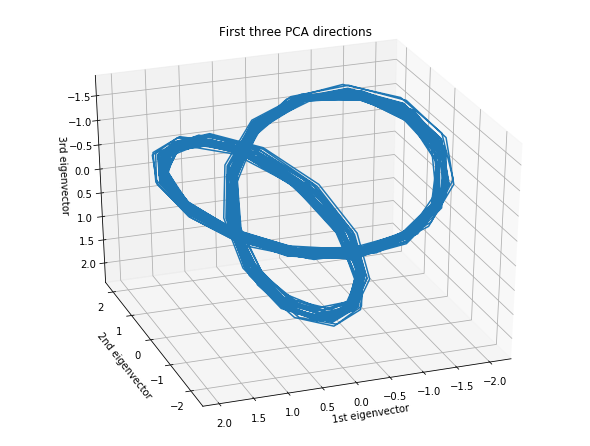

In [29]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
# ax.scatter(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2], cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.plot3D(x_3d[:800, 2], x_3d[:800, 1], x_3d[:800, 0])

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# plt.savefig('pictures/energy_cons_init_3d_traj.eps', bbox_inches='tight')

### 3D

In [30]:
pred_X = ApplyDR(TrajectoryToSpherical(x_3d_centered), 2)

In [31]:
spherical_tr = TrajectoryToSpherical(x_3d_centered)
w_init = np.linalg.lstsq(add_free(spherical_tr[:, :-1]), spherical_tr[:, -1])
y_pred_init = add_free(spherical_tr[:, :-1]).dot(w_init[0])

w_dr = np.linalg.lstsq(add_free(pred_X), spherical_tr[:, -1])
y_pred_dr = add_free(pred_X).dot(w_dr[0])

dr_trajectory = spherical_tr
dr_trajectory[:, -1] = y_pred_dr
dr_trajectory = TrajectoryToCartesian(dr_trajectory)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


In [32]:
y_pred_dr, y_pred_init

(array([2.12261325, 2.21809583, 2.27155174, ..., 2.36871116, 2.35811869,
        2.29942283]),
 array([2.12261325, 2.21809583, 2.27155174, ..., 2.36871116, 2.35811869,
        2.29942283]))

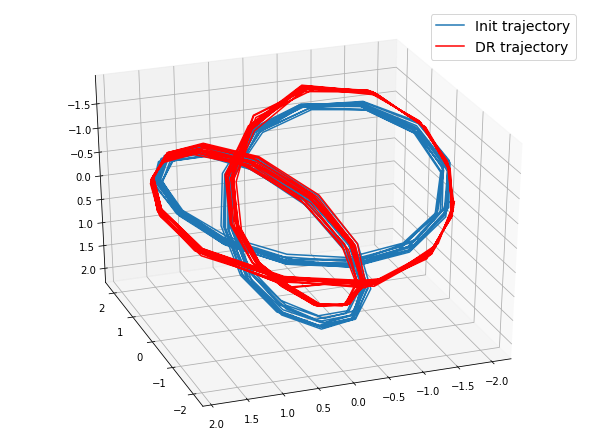

In [33]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d_centered[:300, 2], x_3d_centered[:300, 1], x_3d_centered[:300, 0], label="Init trajectory")
ax.plot3D(dr_trajectory[:300, 2], dr_trajectory[:300, 1], dr_trajectory[:300, 0], label="DR trajectory", c='r')
ax.legend(fontsize=14)

# plt.savefig('pictures/energy_cons_predicted_vs_init.eps', bbox_inches='tight')

### 4D

In [34]:
pca = PCA(n_components=4)
x_4d = pca.fit_transform(H)

center_4d = x_4d.mean(axis=0)
x_4d_centered = x_4d - center_4d

In [35]:
r = 3
pred_X = ApplyDR(TrajectoryToSpherical(x_4d_centered), r=r)

# pred_tr = TrajectoryToSpherical(x_4d_centered)
# pred_tr[:, :-r] = pred_X
# pred_tr = TrajectoryToCartesian(pred_tr)

In [36]:
spherical_tr = TrajectoryToSpherical(x_4d_centered)

w_init = np.linalg.lstsq(add_free(spherical_tr[:, :-1]), spherical_tr[:, -1])
y_pred_init = add_free(spherical_tr[:, :-1]).dot(w_init[0])

w_dr = np.linalg.lstsq(add_free(pred_X), spherical_tr[:, -1])
y_pred_dr = add_free(pred_X).dot(w_dr[0])

dr_trajectory = spherical_tr
dr_trajectory[:, -1] = y_pred_dr
dr_trajectory = TrajectoryToCartesian(dr_trajectory)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [37]:
x_3d_centered[:10], dr_trajectory[:10]

(array([[-0.27166848, -2.02936227,  0.03768122],
        [-1.06788199, -1.71722109,  0.4548478 ],
        [-1.5584565 , -1.10445286,  0.96792848],
        [-1.59067715, -0.36717416,  1.42315278],
        [-1.22733553,  0.29724063,  1.69612306],
        [-0.6035033 ,  0.73595023,  1.69391125],
        [ 0.11213316,  0.86599767,  1.38100187],
        [ 0.69806147,  0.69286897,  0.79748348],
        [ 1.0263307 ,  0.30509874,  0.05665141],
        [ 1.01463224, -0.16152473, -0.691951  ]]),
 array([[-0.29820191, -2.22756682,  0.04136149, -0.8705849 ],
        [-1.17571623, -1.89062531,  0.50077813, -0.79708685],
        [-1.71859033, -1.21793711,  1.06738464, -0.55595758],
        [-1.78400459, -0.4117997 ,  1.59611967, -0.16814199],
        [-1.36713548,  0.3310979 ,  1.88932037,  0.35996547],
        [-0.6790277 ,  0.82804947,  1.90589288,  0.95696875],
        [ 0.12709391,  0.98153869,  1.5652545 ,  1.50885141],
        [ 0.79309185,  0.78719247,  0.90604864,  1.90936185],
        [ 1.

In [38]:
pca = PCA(n_components=3)
dr_trajectory_3d = pca.fit_transform(dr_trajectory)

In [39]:
# %matplotlib notebook

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

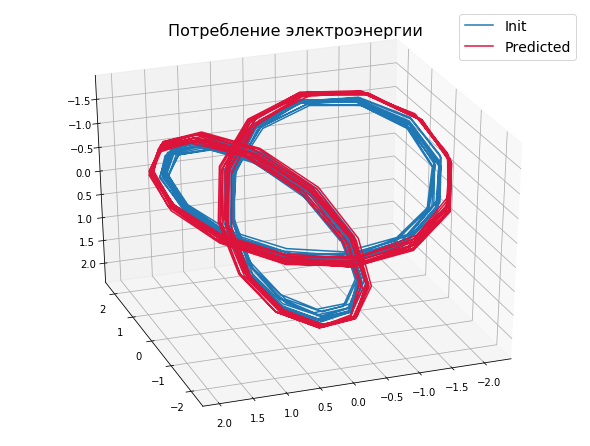

In [43]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d_centered[:300, 2], x_3d_centered[:300, 1], x_3d_centered[:300, 0], label="Init")
ax.plot3D(dr_trajectory[:300, 2], dr_trajectory[:300, 1], dr_trajectory[:300, 0], label="Predicted", c='crimson')

# ax.legend(fontsize=14)

ax.set_title("Потребление электроэнергии", size=16)

# plt.savefig('pictures/energy_cons_predicted_vs_init_legend.eps', bbox_inches='tight')

In [42]:
# 012

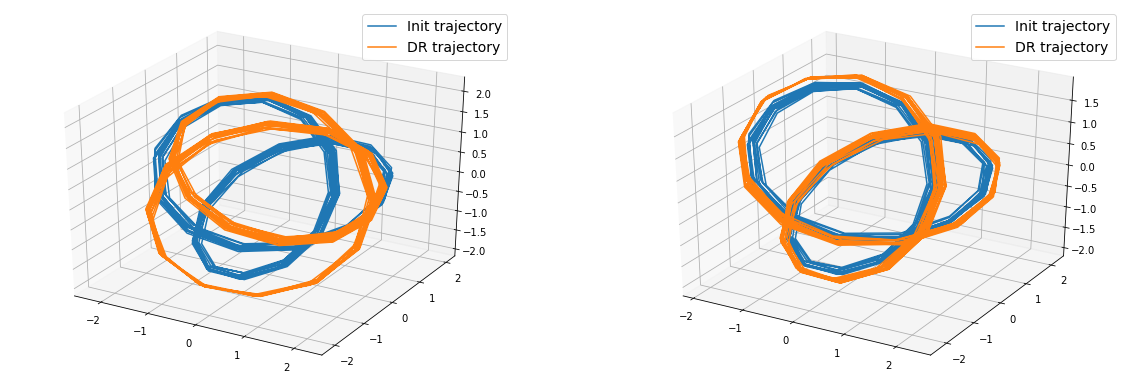

In [49]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(221, projection='3d')
# ax = Axes3D(plot_3d)  
ax.plot3D(x_3d_centered[:300, 0], x_3d_centered[:300, 1], x_3d_centered[:300, 2], label="Init trajectory")
ax.plot3D(dr_trajectory_3d[:300, 1], dr_trajectory_3d[:300, 2], dr_trajectory_3d[:300, 0], label="DR trajectory")
ax.legend(fontsize=14)  

ax = fig.add_subplot(222, projection='3d')
# ax = Axes3D(plot_3d)  
ax.plot3D(x_3d_centered[:300, 0], x_3d_centered[:300, 1], x_3d_centered[:300, 2], label="Init trajectory")
ax.plot3D(dr_trajectory[:300, 0], dr_trajectory[:300, 1], dr_trajectory[:300, 2], label="DR trajectory")
ax.legend(fontsize=14)  

### Новые данные

In [87]:
# data = pd.read_excel('GermanWeather.xls', header=None)

In [47]:
data = pd.read_csv('TurkElectricityConsumption.csv', header=None)

In [10]:
x = np.array(data[6])

mean = x.mean()
std = x.std()
x = MakeStationary((x - mean) / std)

H = HankelMatrix(x[400:1500], L=170)

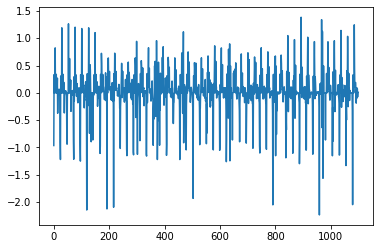

In [50]:
plt.plot(x[400:1500])

In [12]:
pca = PCA(n_components=3)
x_3d = pca.fit_transform(H)

Text(0.5, 0, '3rd eigenvector')

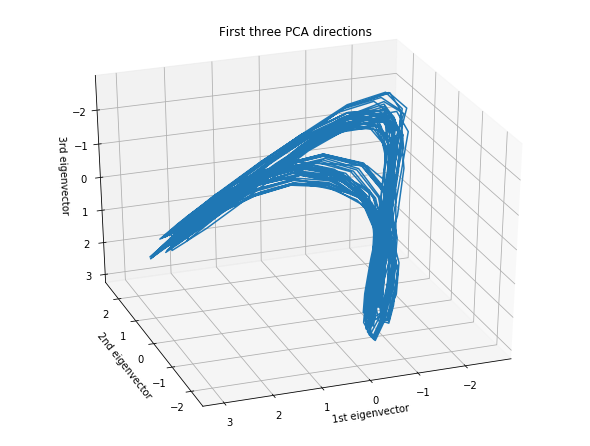

In [13]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2])

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# plt.savefig('pictures/energy_cons_init_3d_traj.eps', bbox_inches='tight')

In [18]:
pca = PCA(n_components=4, random_state=1)
x_4d = pca.fit_transform(H)

In [20]:
r = 3
pred_X = ApplyDR(TrajectoryToSpherical(x_4d), r=r, h=20)

In [22]:
spherical_tr = TrajectoryToSpherical(x_4d)

w_init = np.linalg.lstsq(add_free(spherical_tr[:, :-1]), spherical_tr[:, -1])
y_pred_init = add_free(spherical_tr[:, :-1]).dot(w_init[0])

w_dr = np.linalg.lstsq(add_free(pred_X), spherical_tr[:, -1])
y_pred_dr = add_free(pred_X).dot(w_dr[0])

dr_trajectory = spherical_tr
dr_trajectory[:, -1] = y_pred_dr
dr_trajectory = TrajectoryToCartesian(dr_trajectory)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

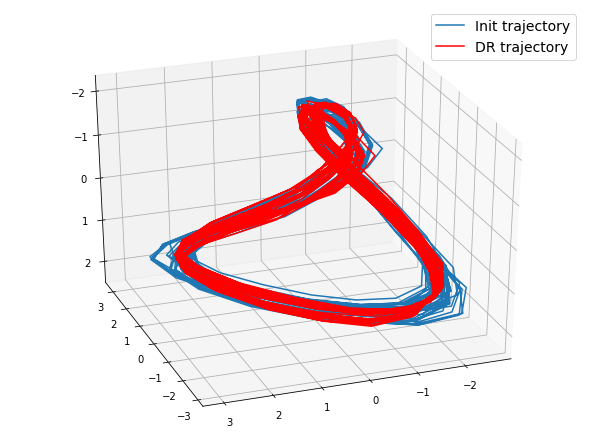

In [39]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:, 0], x_3d[:, 2], x_3d[:, 1], label="Init trajectory")
ax.plot3D(dr_trajectory[:, 0], dr_trajectory[:, 2], dr_trajectory[:, 1], label="DR trajectory", c='r')
ax.legend(fontsize=14)

# plt.savefig('pictures/energy_cons_2_predicted_vs_init.eps', bbox_inches='tight')

### Акселерометр 1

In [17]:
mat_wlk = scipy.io.loadmat('USC-HAD/Subject1/a1t1.mat')['sensor_readings'][:, 0]
scaler = StandardScaler()
x = scaler.fit_transform(mat_wlk[:, np.newaxis])
H = HankelMatrix(x, L=200)

In [18]:
pca = PCA(n_components=3, random_state=1)
x_3d = pca.fit_transform(H)

In [19]:
r = 2
pred_X = ApplyDR(TrajectoryToSpherical(x_3d), r=r, h=20)

In [20]:
spherical_tr = TrajectoryToSpherical(x_3d)

w_dr = np.linalg.lstsq(add_free(pred_X), spherical_tr[:, -1])
y_pred_dr = add_free(pred_X).dot(w_dr[0])

dr_trajectory = spherical_tr
dr_trajectory[:, -1] = y_pred_dr
dr_trajectory = TrajectoryToCartesian(dr_trajectory)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# %matplotlib notebook

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

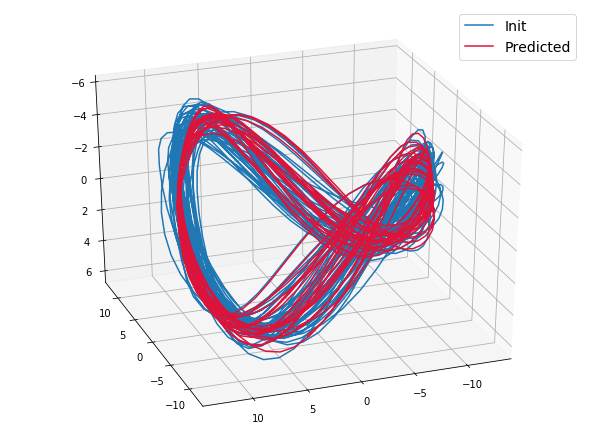

In [25]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2], label="Init")
ax.plot3D(dr_trajectory[:1000, 0], dr_trajectory[:1000, 1], dr_trajectory[:1000, 2], 
          label="Predicted", c='crimson')
# ax.set_title("Акселерометр, ходьба", size=16)
ax.legend(fontsize=14)

# plt.savefig('pictures/accelerometer_predicted_vs_init_legend.eps', bbox_inches='tight')

### Акселерометр 2

In [9]:
mat_wlk = scipy.io.loadmat('USC-HAD/Subject1/a6t1.mat')['sensor_readings'][:, 0]
scaler = StandardScaler()
x = scaler.fit_transform(mat_wlk[:, np.newaxis])
H = HankelMatrix(x, L=200)

In [10]:
pca = PCA(n_components=3, random_state=1)
x_3d = pca.fit_transform(H)

In [11]:
r = 2
pred_X = ApplyDR(TrajectoryToSpherical(x_3d), r=r, h=20)

In [12]:
spherical_tr = TrajectoryToSpherical(x_3d)

w_dr = np.linalg.lstsq(add_free(pred_X), spherical_tr[:, -1])
y_pred_dr = add_free(pred_X).dot(w_dr[0])

dr_trajectory = spherical_tr
dr_trajectory[:, -1] = y_pred_dr
dr_trajectory = TrajectoryToCartesian(dr_trajectory)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# %matplotlib notebook

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

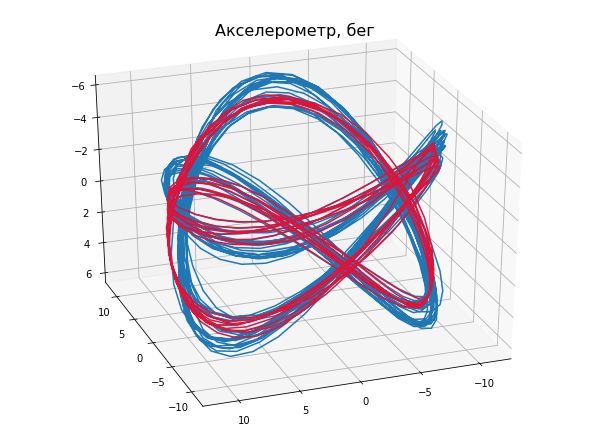

In [16]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2], label="Init")
ax.plot3D(dr_trajectory[:500, 0], dr_trajectory[:500, 1], dr_trajectory[:500, 2], label="Predicted", c='crimson')

# ax.legend(fontsize=14)

ax.set_title("Акселерометр, бег", size=16)

# plt.savefig('pictures/accelerometer_run_predicted_vs_init.eps', bbox_inches='tight')

### Сравниваем разные r 

In [242]:
def CompMse(cart_tr, spherical_tr):
    n_components = cart_tr.shape[1]
    mse_list = []
    for r in range(1, n_components):
        pred_angles = ApplyDR(spherical_tr, r, h=30)

        m = int(pred_angles.shape[0])
        w_dr = np.linalg.lstsq(add_free(pred_angles[:m // 2]), spherical_tr[:m // 2, -1])
        y_pred_dr = add_free(pred_angles[m // 2:]).dot(w_dr[0])

        pred_trajectory = spherical_tr[m // 2:].copy()
        pred_trajectory[:, -1] = y_pred_dr
        pred_trajectory = TrajectoryToCartesian(pred_trajectory)

        mse = np.mean((cart_tr[m // 2:] - pred_trajectory) ** 2)
        mse_list.append(mse)
    return np.array(mse_list)

In [267]:
# accelerometer_wlk
# accelerometer_run
# energy
# energy_2

data_name = "accelerometer_wlk"
picture_filename = 'pictures/mse.eps'

In [268]:
if data_name == 'accelerometer_wlk':
    mat_wlk = scipy.io.loadmat('USC-HAD/Subject1/a1t1.mat')['sensor_readings'][:, 0]
    scaler = StandardScaler()
    x = scaler.fit_transform(mat_wlk[:, np.newaxis])
    H = HankelMatrix(x, L=200)
    picture_filename = 'pictures/accelerometer_mse.eps'
    seed = 42
    title = 'Акселерометр, ходьба'
    # h = 30, seed = 42
elif data_name == 'accelerometer_run':
    mat_run = scipy.io.loadmat('USC-HAD/Subject1/a6t1.mat')['sensor_readings'][:, 0]
    scaler = StandardScaler()
    x = scaler.fit_transform(mat_run[:, np.newaxis])
    H = HankelMatrix(x, L=200)
    picture_filename = 'pictures/accelerometer_run_mse.eps'
    seed = 6
    title = 'Акселерометр, бег'
    # h = 20, seed = 6
elif data_name == 'energy':
    data = pd.read_csv('EnergyConsumption.csv').iloc[:, 3:]
    x = np.array(data["ConsumprionMWtH"])
    mean = x.mean()
    std = x.std()
    x = MakeStationary((x - mean) / std)
    H = HankelMatrix(x[6000:], L=200)
    picture_filename = 'pictures/energy_mse.eps'
    seed = 42
    title = 'Потребление электроэнергии'
    # h = 20, seed = 42
elif data_name == 'energy_2':
    data = pd.read_csv('TurkElectricityConsumption.csv', header=None)
    x = np.array(data[6])
    mean = x.mean()
    std = x.std()
    x = MakeStationary((x - mean) / std)
    H = HankelMatrix(x[400:1500], L=170)
    picture_filename = 'pictures/energy_2_mse.eps'
    seed = 42
    title = ""
else:
    N = 4000
    t_max = 400
    np.random.seed(42)
    # sin(x) + 0.8 * sin(x / 2) + 0.3N(0, 1)
    x = np.sin(np.linspace(0, t_max, N + 1)) + 2 * np.sin(np.linspace(0, t_max, N + 1) / 2) * 0.4 + \
        np.random.randn(N + 1) * 0.3
    H = HankelMatrix(x, L=200)
    picture_filename = 'pictures/gen_mse.eps'
    seed = 42
    title = ""
    
print(data_name)
print(picture_filename)
print(title)

accelerometer_wlk
pictures/accelerometer_mse.eps
Акселерометр, ходьба


In [270]:
n_components = 15
pca = PCA(n_components=n_components, random_state=42)
x_tr = pca.fit_transform(H)

center = x_tr.mean(axis=0)
x_centered = x_tr - center
spherical_tr = TrajectoryToSpherical(x_centered)

In [271]:
mse = CompMse(x_centered, spherical_tr)
mse, picture_filename

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


(array([0.06818494, 0.06817926, 0.06706981, 0.06725438, 0.06720727,
        0.06731184, 0.06714889, 0.06705524, 0.06708362, 0.06708161,
        0.06703151, 0.06703981, 0.06684712, 0.06687061]),
 'pictures/accelerometer_mse.eps')

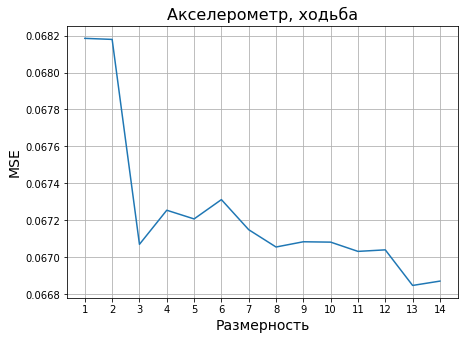

In [273]:
plt.figure(figsize=(7, 5))
plt.plot(list(range(1, n_components)), mse)
plt.grid()
plt.xticks(range(1, n_components))
plt.xlabel("Размерность", size=14)
plt.ylabel("MSE", size=14)
plt.title(title, size=16)

# plt.savefig(picture_filename, bbox_inches='tight')